### 사용한 라이브러리

In [46]:
#기본 및 통계
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean

#최단거리 계산
import geopandas as gpd
from haversine import haversine

#지도 시각화
import folium as g

# 시각화
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

#경고 무시
import warnings
warnings.filterwarnings(action='ignore')

### 데이터 불러오기

In [47]:
# 지역 선정을 위한 데이터
sf = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/가뭄피해정보.xlsx')

da1 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/가뭄피해정보.xlsx')
da2 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/기뭄지수.xlsx')
da3 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/농업면적.xlsx')
da4 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/농업인수.xlsx')

#군집화 및 저수지 선정을 위한 데이터
df = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/경기도 종합정보.xlsx')
df2 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/가뭄피해정보.xlsx')

#시각화용 데이터
b1 = pd.read_excel('/Users/home/Desktop/대국민 물 공모전/가뭄피해정보.xlsx')

### 데이터 전처리

In [48]:
#시각화용 전처리
sf1 = sf[['피해종료일','피해인구']]
sf1 = sf1.sort_values('피해종료일',ascending=True)
sf1 = sf1.fillna(method='ffill')
sf1['피해종료일'] = sf1['피해종료일'].astype('str')
sf1['피해종료일'] = sf1['피해종료일'].str[0:4]
s1 = sf1.groupby(['피해종료일'],as_index=False).sum()
s1['피해종료일'] = s1['피해종료일'].astype('str')

sf2 = sf[['피해시작일','피해인구']]
sf2 = sf2.sort_values('피해시작일',ascending=True)
sf2['피해시작일'] = sf2['피해시작일'].astype('str')
sf2['피해시작일'] = sf2['피해시작일'].str[0:4]
s2 = sf2.groupby(['피해시작일'],as_index=False).sum()
s2['피해시작일'] = s2['피해시작일'].astype('str')

#지역 선정 데이터 전처리

#중복 및 결측치 제거
da2 = da2.drop_duplicates(['지점명'])
da3 = da3.fillna(method='ffill')
da3 = da3.drop(da3[da3['시도별']=='전국'].index)
da3 = da3.drop(da3[da3['전답별']=='밭'].index)
da4 = da4.drop(da4[da4['행정구역별']=='행정구역별'].index)
da4 = da4.drop(da4[da4['행정구역별']=='전국'].index)

# 피해종료일의 결측치는 아직 진행중인거로 생각하여 2021 데이터로 사용해주기 위해 마지막 날짜와 겹치게 해주겠습니다/로 대체해줍니다.
da1 = da1.sort_values('피해종료일',ascending=True)
da1['피해종료일'] = da1['피해종료일'].fillna(method='ffill')


da2['시도'].loc[(da2['지점명']=='광주')]='광주광역시'

da1['피해종료일'] =da1['피해종료일'].astype('str')
da1['피해종료일'] =da1['피해종료일'].str[0:4]

da1 = da1[da1['피해종료일']>='2016']


#시도 기준으로 전답별 계만 남겨두고 데이터프레임 옆에 논을 따로 추가해 줍니다.
d3 = da3.drop_duplicates(['시도별'])
dd3 = da3[da3['전답별']=='논']
d3 = pd.merge(d3,dd3,on='시도별',how='left')

# 전체 면적이 아닌 논의 규모를 우선으로 하여 논면적에 전체 면적을 나눠줍니다.
a = []
for i in d3['2021_y']/d3['2021_x']:
    a.append(i)
d3['계산'] = a

# 필요 데이터 모음
da1 = da1[['시도','피해인구']]
da2 = da2[['시도','spi12']]
da3 = da3[['시도별','전답별','2021']]
d3 = d3[['시도별','계산']]
da4 = da4[['행정구역별','2021']]

# 가뭄피해인구와 가뭄지수 시군구와 같이 나눠지므로 평균으로 정리합니다.
d1 = da1.groupby(['시도'],as_index=False).sum()
d2 = da2.groupby(['시도'],as_index=False).mean()

#시도를 기준으로 묶기 위해서 이름 변경
d3 = d3.rename(columns={'시도별':'시도'})
d4 = da4.rename(columns={'행정구역별':'시도'})

#전체 시도별로 묶어 정리
dro = pd.merge(d1,d2,on='시도',how='left')
dro = pd.merge(dro,d3,on='시도',how='left')
dro = pd.merge(dro,d4,on='시도',how='left')
dro = dro.fillna(0)
dro['농업인구'] = dro['2021']
dro['농업면적'] = dro['계산']
dro['농업인구'] = dro['농업인구'].astype('float')

dro = dro[['시도','농업인구','spi12','피해인구','농업면적']]

In [49]:
#경기도 정보 중 필요 데이터만 정리

df1 = df[['위치','시설명','저수율(%)','수질등급','lon','lat']]
df1['저수율'] = df1['저수율(%)']
df1['위치'] =df1['위치'].str[0:12]

#가뭄 피해정보중 경기도만 정리
df2 = df2[df2['시도']=='경기도']
df2['피해종료일'].replace(' ',2022, inplace = True)
df2['피해종료일'] =df2['피해종료일'].astype('str')
df2['피해종료일'] =df2['피해종료일'].str[0:4]
df2 = df2[df2['피해종료일']>='2016']
df3 = df2[['lon','lat']]
df3['지역'] = df2['시도']+ " "+ df2['시군구']+" "+df2['읍면동'] 
df3 = df3[['지역','lon','lat']]
df3 = df3.reset_index(drop=True)

# 수질등급을 문자에서 각각의 성능별로 숫자 부여
# 점수를 부여할 예정이므로 1-7을 붙여 구해줍니다.
df1.replace('I a', 1, inplace = True)
df1.replace('I b', 2, inplace = True)
df1.replace('II', 3, inplace = True)
df1.replace('III', 4, inplace = True)
df1.replace('IV', 5, inplace = True)
df1.replace('V', 6, inplace = True)
df1.replace('VI', 7, inplace = True)
df1 = df1.reset_index(drop=True)
df1['수질등급'] = df1['수질등급'].astype('float')

### 피해인구 시각화

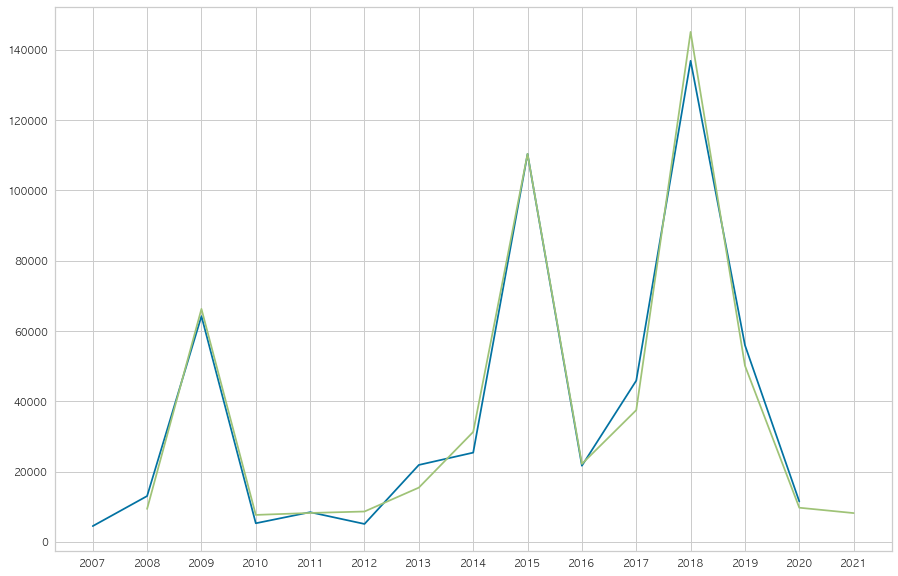

In [50]:
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15,10))

plt.plot(s2['피해시작일'],s2['피해인구'])
plt.plot(s1['피해종료일'],s1['피해인구'])

plt.show()

### 지역선정 AHP 분석

In [51]:
#농업 인구, 가뭄지수, 피해 인구, 농업 면적 순으러 우선순위를 부여해줍니다.
np01 = np.array([[1,1/5,3,3],[5,1,3,5],[1/3,1/3,1,5],[1/3,1/5,1/5,1]])

col_sums = np01.sum(axis=0)#열들의 합

np02 = np01 / col_sums#정규화

row_avg = np02.mean(axis=1)#가중치 계산
row_avg
np01

array([[1.        , 0.2       , 3.        , 3.        ],
       [5.        , 1.        , 3.        , 5.        ],
       [0.33333333, 0.33333333, 1.        , 5.        ],
       [0.33333333, 0.2       , 0.2       , 1.        ]])

In [52]:
np03 = np01.dot(row_avg[:, np.newaxis]) # 쌍대비교행렬과 가중치 행렬의 곱
np04 = np03/row_avg[:, np.newaxis] # 곱한 행렬의 각 값을 가중치로 나눔
consistency = (np04.mean(axis=0)-4)/3 # 일관성 지수 계산 요소의 개수를 빼고 개수보다 1작은 수로 나눔
print('3번 결과(일관성 지수) : {}'.format(consistency))

3번 결과(일관성 지수) : [0.17192817]


In [53]:
# 가중치를 구한것을 각각의 열에 곱해서 점수를 부여해줌 크기가 큰 것은 로그 값을 씌어줌
aa = row_avg[0]*(dro['spi12']*(-1))/max(dro['spi12']*(-1))
bb = row_avg[1]*(np.log(dro['피해인구']))/max(np.log(dro['피해인구']))
cc = row_avg[2]*(dro['농업면적'])/max(dro['농업면적'])
dd = row_avg[3]*(np.log(dro['농업인구']))/max(np.log(dro['농업인구']))
ee = 100*(aa+bb+cc+dd)
dro['점수'] = ee
dro = dro.sort_values('점수',ascending=False)
dro['rank'] = dro['점수'].rank(ascending=False)
dro = dro[['rank','점수','시도']]
dro

,rank,점수,시도
1,1.0,88.093042,경기도
0,2.0,86.658567,강원도
7,3.0,83.217920,인천광역시
9,4.0,68.706044,전라북도
8,5.0,67.819789,전라남도
10,6.0,65.668679,충청남도
11,7.0,64.311809,충청북도
2,8.0,53.298016,경상남도
3,9.0,50.391411,경상북도
5,10.0,46.851308,세종특별자치시


### 위경도를 통한 최단 거리 구하기

In [54]:
re_location = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(df1.lon, df1.lat), crs='epsg:4326')
dr_location = gpd.GeoDataFrame(df3, geometry=gpd.points_from_xy(df3.lon, df3.lat), crs='epsg:4326')

def location(lo):
    distances =  dr_location.to_crs(epsg=5186).geometry.distance(lo)
    loc = dr_location.iloc[distances.idxmin()]['지역']
    return loc
re_location['지역'] = re_location.to_crs(epsg=5186).apply(lambda x: location(x.geometry), axis=1)

In [55]:
dr_location = dr_location.drop_duplicates()
dis = pd.merge(re_location,dr_location,on='지역',how='left')

In [56]:
from haversine import haversine
li = []

dis['lon_x'] = dis['lon_x'].astype('float')
dis['lat_x'] = dis['lat_x'].astype('float')
dis['lon_y'] = dis['lon_y'].astype('float')
dis['lat_y'] = dis['lat_y'].astype('float')

for i in range(dis.shape[0]):
    hbl = (dis['lon_x'][i],dis['lat_x'][i])
    hcl = (dis['lon_y'][i],dis['lat_y'][i])
    result = haversine(hbl,hcl,unit='km')
    li.append(result)


In [57]:
re_location['최단거리'] = li
df1 = re_location[['위치','시설명','저수율','수질등급','최단거리','lon','lat']]
df1 = df1.sort_values('위치',ascending=False)

#점수 부여시 저수지 명칭을 가져오기 위해 따로 만들어줍니다.
ddf1 = pd.DataFrame(df1)
ddf1['시설명'] = df1['시설명']
ddf1['지역명'] = df1['위치']

df1 = re_location[['위치','저수율','수질등급','최단거리']]

In [58]:
a=[]
for i in df1['위치']:
    if i not in a:
        a.append(i)
        
for i in range(len(a)):
    for j in range(len(a)):
        if i == j:
            df1.replace(f'{a[i]}', j, inplace = True)
            
df1['위치'] = df1['위치'].astype('float')
df1 = df1.dropna()
df1

,위치,저수율,수질등급,최단거리
0,0.0,99.2,2.0,11.408298
1,1.0,82.3,1.0,5.396389
2,2.0,74.5,4.0,5.081344
3,3.0,70.3,3.0,15.169634
4,4.0,78.0,7.0,41.554381
...,...,...,...,...
91,65.0,75.6,4.0,2.502379
92,66.0,73.9,6.0,3.327161
93,67.0,74.2,4.0,1.682637
94,68.0,71.4,3.0,2.152303


### 최단거리 구한 것을 통해 정규화를 진행

In [59]:
from sklearn.preprocessing import MinMaxScaler

# 세가지 feature를 대상
data = df1[['저수율','수질등급','최단거리']]

# 정규화 진행
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

### k-means

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f882d158520>,
                 estimator=KMeans(n_clusters=9), k=None)

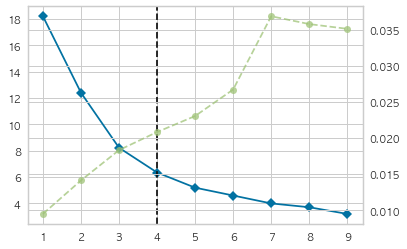

In [60]:
# 엘보우를 통한 최적의 군집수 계산
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

In [61]:
k = 4

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df1['cluster'] = model.fit_predict(data_scale)

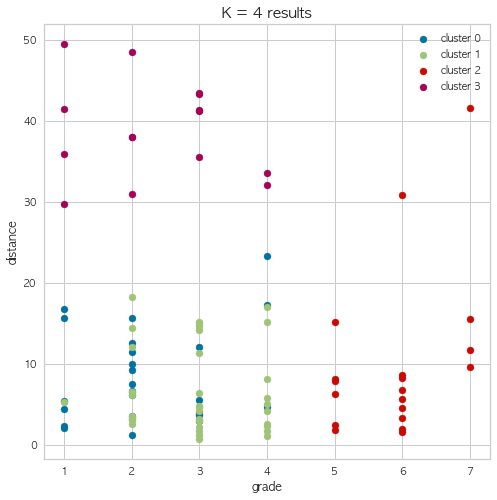

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df1.loc[df1['cluster'] == i, '수질등급'], df1.loc[df1['cluster'] == i,'최단거리'],
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('grade', size = 12)
plt.ylabel('distance', size = 12)
plt.show()

### 저수지 데이터 AHP분석

In [63]:
df1['시설명'] = ddf1['시설명']
df1['지역명'] = ddf1['지역명']
df1['lon'] = ddf1['lon']
df1['lat'] = ddf1['lat']
df1 = df1.drop_duplicates()

In [64]:
A0 = df1[df1['cluster']==0]
A1 = df1[df1['cluster']==1]
A2 = df1[df1['cluster']==2]
A3 = df1[df1['cluster']==3]

In [65]:
np01 = np.array([[1,5,3],[1/5,1,3],[1/3,1/3,1]])

col_sums = np01.sum(axis=0)
np02 = np01 / col_sums
row_avg = np02.mean(axis=1)

row_avg

array([0.62340634, 0.23896698, 0.13762668])

In [66]:
np03 = np01.dot(row_avg[:, np.newaxis]) # 1번
np04 = np03/row_avg[:, np.newaxis] # 2번
consistency = (np04.mean(axis=0)-3)/2 # 3번, 일관성 지수

print('3번 결과(일관성 지수) : {}'.format(consistency))

3번 결과(일관성 지수) : [0.15285312]


### 지도 시각화

In [67]:
g_map = g.Map(location=[37,127],zoom_start=7)

In [68]:
# cluster0
for i in range(len(A0)):
    marker00 = g.Marker([A0.iloc[i]['lat'],A0.iloc[i]['lon']],icon = g.Icon(color='blue'))
    marker00.add_to(g_map)
# cluster1
for i in range(len(A1)):
    marker01 = g.Marker([A1.iloc[i]['lat'],A1.iloc[i]['lon']],icon = g.Icon(color='green'))
    marker01.add_to(g_map)

# cluster2
for i in range(len(A2)):
    marker02 = g.Marker([A2.iloc[i]['lat'],A2.iloc[i]['lon']],icon = g.Icon(color='red'))
    marker02.add_to(g_map)

# cluster3
for i in range(len(A3)):
    marker03 = g.Marker([A3.iloc[i]['lat'],A3.iloc[i]['lon']],icon = g.Icon(color='black'))
    marker03.add_to(g_map)
    
g_map

### 각 군집별 저수지 점수 계산

In [69]:
aa = row_avg[0]*(1/(A0['수질등급']))/max(1/(A0['수질등급']))
bb = row_avg[1]*(1/(A0['최단거리']))/max(1/(A0['최단거리']))
cc = row_avg[2]*(A0['저수율'])/max(A0['저수율'])

ee = 100*(aa+bb+cc)
A0['점수'] = ee
A0['rank'] = A0['점수'].rank(ascending=False)
A0 = A0.sort_values('rank',ascending=True)
A0['rank'] = A0['rank'].astype('int')
A0 = A0[['rank','점수','수질등급','시설명','지역명']]
A0

,rank,점수,수질등급,시설명,지역명
40,1,88.100026,1.0,단석,경기도 양평군 양동면
21,2,87.991491,1.0,미장,경기도 안성시 삼죽면
62,3,81.679393,1.0,용면,경기도 이천시 신둔면
1,4,78.787596,1.0,도척,경기도 광주시 도척면
79,5,75.822699,1.0,중리,경기도 포천시 관인면
87,6,75.585483,1.0,추동,경기도 포천시 창수면
43,7,68.306702,2.0,월산,경기도 양평군 지평면
38,8,52.809510,2.0,부리,경기도 양평군 개군면
86,9,48.717701,2.0,둔지,경기도 포천시 일동면
72,10,48.446121,2.0,동막,경기도 평택시 지산동


In [70]:
aa = row_avg[0]*(1/(A1['수질등급']))/max(1/(A1['수질등급']))
bb = row_avg[1]*(1/(A1['최단거리']))/max(1/(A1['최단거리']))
cc = row_avg[2]*(A1['저수율'])/max(A1['저수율'])

ee = 100*(aa+bb+cc)
A1['점수'] = ee

A1['rank'] = A1['점수'].rank(ascending=False)
A1 = A1.sort_values('rank',ascending=True)
A1['rank'] = A1['rank'].astype('int')
A1 = A1[['rank','점수','수질등급','시설명','지역명']]
A1

,rank,점수,수질등급,시설명,지역명
44,1,76.719555,1.0,금사(장흥),경기도 여주시 금사면
20,2,56.962608,3.0,덕산,경기도 안성시 삼죽면
61,3,50.775142,2.0,고척,경기도 이천시 신둔면
56,4,49.279255,2.0,용덕,경기도 용인시 처인구
53,5,48.915782,2.0,삼인동,경기도 용인시 처인구
51,6,48.538472,2.0,서랑,경기도 오산시 서랑동
84,7,46.955822,2.0,기산,경기도 포천시 일동면
23,8,46.563660,2.0,청용,경기도 안성시 서운면
6,9,45.803890,2.0,대왕,경기도 성남시 수정구
81,10,44.535909,2.0,산정,경기도 포천시 영북면


In [71]:
aa = row_avg[0]*(1/(A2['수질등급']))/max(1/(A2['수질등급']))
bb = row_avg[1]*(1/(((A2['최단거리']))/max(1/(A2['최단거리']))))
cc = row_avg[2]*(A2['저수율'])/max(A2['저수율'])

ee = 100*(aa+bb+cc)
A2['점수'] = ee
A2['rank'] = A2['점수'].rank(ascending=False)
A2 = A2.sort_values('rank',ascending=True)
A2['rank'] = A2['rank'].astype('int')
A2 = A2[['rank','점수','수질등급','시설명','지역명','lon','lat']]
A2

,rank,점수,수질등급,시설명,지역명,lon,lat
5,1,82.463996,5.0,낙생,경기도 성남시 분당구,127.078305,37.350319
55,2,77.492540,5.0,용담,경기도 용인시 처인구,127.306111,37.191672
89,3,75.764842,5.0,어천,경기도 화성시 매송면,126.913700,37.253208
48,4,74.995627,5.0,신근,경기도 여주시 흥천면,127.559260,37.309390
88,5,74.822664,5.0,송라,경기도 화성시 매송면,126.900016,37.282928
60,6,71.718493,6.0,성호(설성),경기도 이천시 설성면,127.534601,37.142115
12,7,71.068622,5.0,흥부,경기도 시흥시 물왕동,126.831512,37.384862
17,8,68.471913,6.0,거청,경기도 안성시 대덕면,127.240532,37.024469
71,9,67.307565,6.0,월곡,경기도 평택시 월곡동,127.130301,37.020553
92,10,66.766490,6.0,버들,경기도 화성시 장안면,126.829077,37.129597


In [72]:
aa = row_avg[0]*(1/(A3['수질등급']))/max(1/(A3['수질등급']))
bb = row_avg[1]*(1/(A3['최단거리']))/max(1/(A3['최단거리']))
cc = row_avg[2]*(A3['저수율'])/max(A3['저수율'])

ee = 100*(aa+bb+cc)
A3['점수'] = ee
A3['rank'] = A3['점수'].rank(ascending=False)
A3 = A3.sort_values('rank',ascending=True)
A3['rank'] = A3['rank'].astype('int')
A3 = A3[['rank','점수','수질등급','시설명','지역명']]
A3

,rank,점수,수질등급,시설명,지역명
49,1,100.000000,1.0,황지,경기도 연천군 군남면
32,2,94.104377,1.0,신암,경기도 양주시 남면 신
64,3,90.626020,1.0,마장,경기도 파주시 광탄면
69,4,89.044761,1.0,금파,경기도 파주시 파평면
36,5,65.343097,2.0,남방,경기도 양주시 어둔동
34,6,60.818796,2.0,기산,경기도 양주시 백석읍
66,7,58.478154,2.0,애룡,경기도 파주시 법원읍
31,8,50.979738,3.0,효촌,경기도 양주시 남면 두
37,9,50.452205,4.0,봉암,경기도 양주시 은현면
33,10,48.326016,4.0,원당,경기도 양주시 남면 황


### 부가적인 활용을 위한 저수지 저수량 확인

In [73]:
dfff1 = df[['위치','시설명','...5']]
dfff1 = dfff1.rename(columns={'...5':'유효저수량(천m3)'})
A0

,rank,점수,수질등급,시설명,지역명
40,1,88.100026,1.0,단석,경기도 양평군 양동면
21,2,87.991491,1.0,미장,경기도 안성시 삼죽면
62,3,81.679393,1.0,용면,경기도 이천시 신둔면
1,4,78.787596,1.0,도척,경기도 광주시 도척면
79,5,75.822699,1.0,중리,경기도 포천시 관인면
87,6,75.585483,1.0,추동,경기도 포천시 창수면
43,7,68.306702,2.0,월산,경기도 양평군 지평면
38,8,52.809510,2.0,부리,경기도 양평군 개군면
86,9,48.717701,2.0,둔지,경기도 포천시 일동면
72,10,48.446121,2.0,동막,경기도 평택시 지산동


In [74]:
#저수지의 시설명을 기준으로 병합을 진행해 저수량을 묶어줍니다
AA0 = pd.merge(A0,dfff1,on='시설명',how='left')
AA0 = AA0[['수질등급','시설명','지역명','유효저수량(천m3)']]
AA0 = AA0.sort_values('유효저수량(천m3)',ascending=False)
AA0

,수질등급,시설명,지역명,유효저수량(천m3)
12,2.0,광혜,경기도 안성시 죽산면,3606.4
14,2.0,고모,경기도 포천시 소흘읍,1108.4
10,2.0,청계,경기도 과천시 막계동,1083.8
18,3.0,대평,경기도 양평군 지평면,968.7
15,2.0,우금,경기도 포천시 가산면,816.5
3,1.0,도척,경기도 광주시 도척면,576.6
19,3.0,금주,경기도 포천시 영중면,559.3
4,1.0,중리,경기도 포천시 관인면,457.2
21,4.0,향리,경기도 양평군 개군면,435.4
2,1.0,용면,경기도 이천시 신둔면,261.9
